## Домашнее задание №6

В данном задании мы попробуем решить задачу классификации текстов, при этом попробуем воспользоваться информативными векторными описаниями слов, о которых рассказывалось на лекции.

Идея решения данной задачи заключается в следующем.
Мы попробуем построить бинарный классификатор, основанный на нейронных сетях и логистической регрессии. Ему на вход подаётся некоторый вектор признаков. На выходе - значение предсказания построенной модели логистической регрессии (одно число).

В качестве признаков предлагается использовать векторное представление текста. Это может быть либо классическая модель мешка слов, либо модель мешка эмбеддингов. Соответственно, модель должна по заданному векторному представлению каждого текста предсказать вероятности соответствующих классов.
Т.е. нам нужно самостоятельно реализовать аналог sklearn.linear_model.LogisticRegression с помощью библиотеки PyTorch.

In [2]:
# Не меняйте следующий блок кода! Он потребуется для дальнейшей работы
# __________start of block__________
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm



from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


out_dict = dict()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# __________end of block__________

### Предобработка текста и токенизация



Для начала скачаем исходные данные:

In [3]:
df = pd.read_csv( # Считываем исходный набор данных, разделитель - символ табуляции, заголовок отсутствует
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)
df.head(5) # Посмотрим на первые 5 строк в считанном наборе данных

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


Исходный набор данных представляет собой список отзывов на различные фильмы, а также тональность соответствующего отзыва (положительный или отрицательный). Вам нужно решить задачу сентимент-анализа, т.е. построить бинарный классификатор, который позволит по известному отзыву сказать, положительный он или отрицательный.

Предобработка входных данных достаточно проста и подробно описывается в комментариях к коду.

Библиотека [`nltk`](https://www.nltk.org) широко используется при обработке текстов. По ссылке выше можно найти ее развернутое описание и документацию.

In [4]:
# Не изменяйте следующий блок кода! Он нужен для корректной предобработки входных данных

# __________start of block__________

texts_train = df[0].values[:5000] # В качестве обучающей выборки выбираем первые 5000 предложений
y_train = df[1].values[:5000] # Каждому предложению соответствует некоторая метка класса - целое число
texts_test = df[0].values[5000:] # В качестве тестовой выборки используем все оставшиеся предложения
y_test = df[1].values[5000:]

from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer() # В качестве токенов будем использовать отдельные слова и знаки препинания

# В качестве предобработки будем приводить текст к нижнему регистру.
# Предобработанный текст будем представлять в виде выделенных токенов, разделённых пробелом
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),) # Посмотрим, как работает предобработка для заданной строки text

texts_train = [preprocess(text) for text in texts_train] # Получаем предобработанное представление для тренировочной выборки
texts_test = [preprocess(text) for text in texts_test] # Аналогично получаем предобработанное представление для тестовой выборки

# Выполняем небольшие проверки того, насколько корректно были обработаны тренировочная и тестовая выборки
assert texts_train[5] ==  'campanella gets the tone just right funny in the middle of sad in the middle of hopeful'
assert texts_test[74] == 'poetry in motion captured on film'
assert len(texts_test) == len(y_test)
# __________end of block__________

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown - up at work : replace " i don ' t want to do that " with " ok , great !".


Следующие функции помогут вам с визуализацией процесса обучения сети.

In [5]:
# Не изменяйте блок кода ниже!

# __________start of block__________
def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(' '.join(['Loss', title_suffix]))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title(' '.join(['Validation accuracy', title_suffix]))
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()
    plt.show()

def visualize_and_save_results(model, model_name, X_train, X_test, y_train, y_test, out_dict):
    for data_name, X, y, model in [
    ('train', X_train, y_train, model),
    ('test', X_test, y_test, model)
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X.to(device)).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError('Unrecognized model type')

        auc = roc_auc_score(y, proba)

        out_dict['{}_{}'.format(model_name, data_name)] = auc
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (data_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.title(model_name)
    plt.grid()
    return out_dict
# __________end of block__________

### Задача №1. Мешок слов.

На лекции рассматривались подходы, позволяющие представить отдельные токены в виде векторов. Однако, в реальной жизни мы работаем с полноценными текстами.

Как известно из лекции, **текст** -- последовательность токенов, длина которой **не фиксирована**. Соответственно, если каждый текст представлять матрицей, где каждый столбец будет являться векторным описанием очередного токена, мы будем получать для разных текстов матрицы разного размера. Как мы знаем, такие матрицы непригодны для передачи в нейронные сети, поскольку размер входных данных сети - всегда фиксирован. Поэтому нужно научиться представлять любой текст некоторым тензором (вектором или матрицей) фиксированного размера.

Самый простой способ -- воспользоваться классическим подходом к векторизации текстов: мешком слов. На лекции упоминалось, что в таком подходе каждый токен может быть закодирован разреженным вектором, размер которого будет равен размеру словаря. Соответственно, чтобы получить векторное представление всего текста, достаточно сложить векторные представления всех входящих в него токенов.

Первое, что мы рассмотрим - One-hot кодирование токенов. В этом случае мы приходим к тому, что текст будет представлен вектором, длина которого равна размеру словаря, N-ым значением в этом векторе будет количество употребления слова с индексом N в исходном тексте.

Для реализации такого подхода вы можете как воспользоваться `CountVectorizer` из `sklearn`, так и самостоятельно реализованный вариант. Обращаем ваше внимание, в данной задаче используется лишь `k` наиболее часто встречаемых слов из обучающей части выборки.

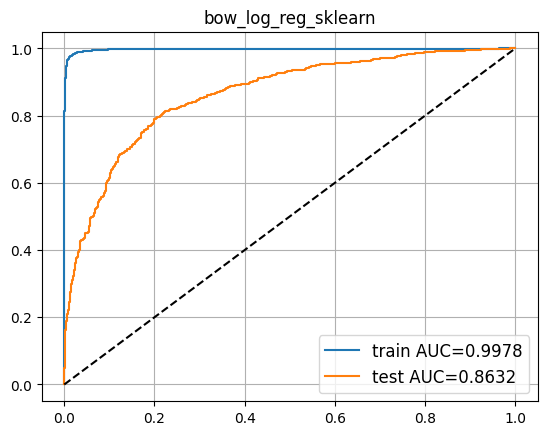

In [ ]:
# Не изменяйте блок кода ниже!

# __________start of block__________

# Отбираем только k наиболее популярных слов в текстах

k = min(10000, len(set(' '.join(texts_train).split()))) # Если в словаре меньше 10000 слов, то берём все слова, в противном случае выберем 10000 самых популярных

# Построим словарь всех уникальных слов в обучающей выборке,
# оставив только k наиболее популярных слов.

counts = Counter(' '.join(texts_train).split())
bow_vocabulary = [key for key, val in counts.most_common(k)]


def text_to_bow(text):
    """ Функция, позволяющая превратить входную строку в векторное представление на основании модели мешка слов. """
    sent_vec = np.zeros(len(bow_vocabulary))
    counts = Counter(text.split())
    for i, token in enumerate(bow_vocabulary):
        if token in counts:
            sent_vec[i] = counts[token]
    return np.array(sent_vec, 'float32')

X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

# Небольшие проверки - они нужны, если Вы захотите реализовать собственную модель мешка слов.
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[65, bow_vocabulary.index('!')] == texts_train[65].split().count('!')


# Строим модель логистической регрессии для полученных векторных представлений текстов
bow_model = LogisticRegression(max_iter=1500).fit(X_train_bow, y_train)

out_dict = visualize_and_save_results(bow_model, 'bow_log_reg_sklearn', X_train_bow, X_test_bow, y_train, y_test, out_dict)
# __________end of block__________

In [ ]:
k, len(bow_vocabulary)

(10000, 10000)

Результаты неплохие, но явно видно переобучение. Этот вывод можно сделать судя по значительному превосходству качества (AUC ROC) на train выборке относительно test. Более того, на обучающей выборке качество стремится к единице, в то время как на отложенной – значительно ниже, т.е. модель уловила множество зависимостей, свойственных лишь обучающей выборке. Базово проблема переобучения рассматривалась в курсе Машинного обучения. Более подробно она еще не раз встретится при дальнейшем прохождении курса.

В данной задаче с переобучением мы разберемся в дальнейшем. Сейчас же реализуйте решение на основе логистической регрессии, но уже используя PyTorch. В результате вам должна быть доступна обученная модель, предсказывающая вероятности для двух классов. Качество на тестовой выборке должно не уступать логистической регрессии.

Таким образом, нужно реализовать однослойную линейную сеть с использованием softmax в качестве функции активации и количеством выходов, равному количеству классов.

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(len(bow_vocabulary), 2)

  def forward(self, x):
    x = self.fc(x)

    return F.sigmoid(x)

# device = torch.device('cpu')

model = Model()
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train_bow_torch = torch.tensor(X_train_bow)
X_test_bow_torch = torch.tensor(X_test_bow)

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

Не забывайте о функциях потерь: `nn.CrossEntropyLoss` объединяет в себе `LogSoftMax` и `NLLLoss`. Также не забывайте о необходимости перенести тензоры на используемый `device`.

Функция ниже поможет с обучением модели. Часть кода необходимо реализовать самостоятельно.

In [ ]:
def train_model(
    model,
    opt,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    show_plots=True,
    eval_every=50
):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in tqdm(range(n_iterations)):

        # Получаем случайный батч размера batch_size для проведения обучения
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # Предсказываем отклик (log-probabilities или logits)
        y_predicted = model(x_batch.to(device))

        # Вычисляем loss, как и выше
        loss = loss_function(y_predicted, y_batch.to(device))

        # Вычисляем градиенты
        loss.backward()

        # Adam step
        opt.step()

        # clear gradients
        opt.zero_grad()

        local_train_loss_history.append(loss.item())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch.to(device))
            val_loss_history.append(loss_function(predictions_val, y_val_torch.to(device)).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

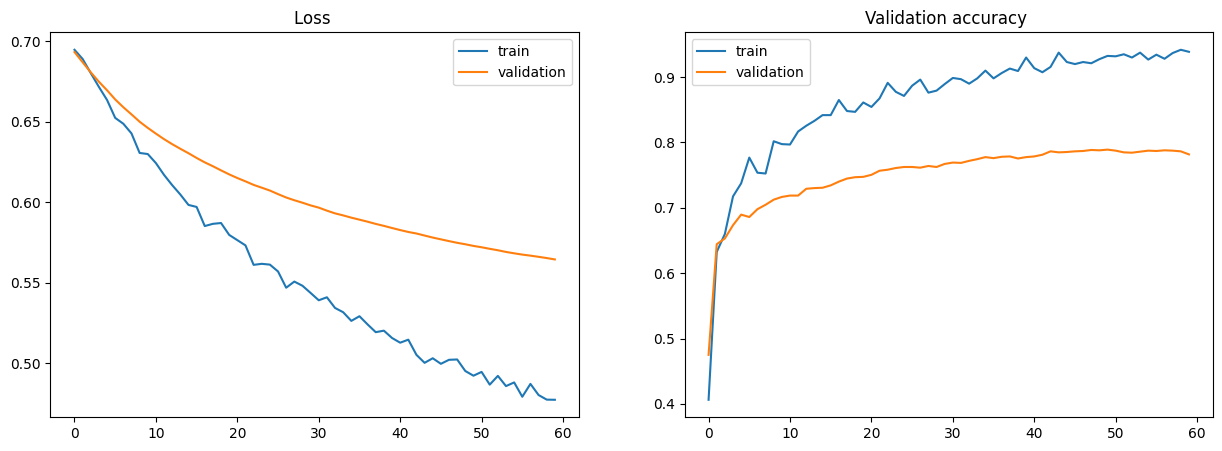

In [ ]:
bow_nn_model = train_model(model, opt, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, n_iterations=3000)


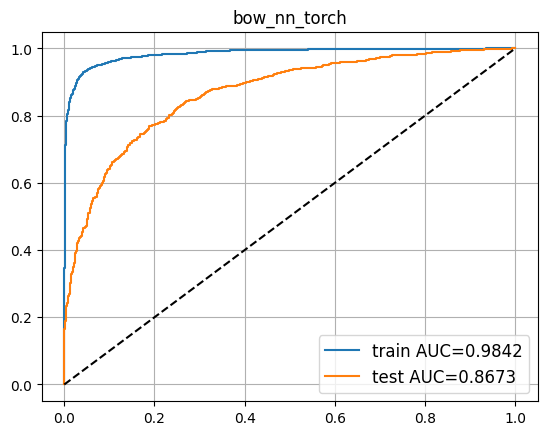

In [ ]:
# Не изменяйте блок кода ниже!
# __________start of block__________
out_dict = visualize_and_save_results(bow_nn_model, 'bow_nn_torch', X_train_bow_torch, X_test_bow_torch, y_train, y_test, out_dict)

assert out_dict['bow_log_reg_sklearn_test'] - out_dict['bow_nn_torch_test'] < 0.01, 'AUC ROC on test data should be close to the sklearn implementation'
# __________end of block__________

А теперь повторите процедуру обучения выше, но для различных значений `k` – размера словаря. В список results сохраните `AUC ROC` на тестовой части выборки для модели, обученной со словарем размера `k`.

In [ ]:
out_dict

{'bow_log_reg_sklearn_train': 0.9977842611208917,
 'bow_log_reg_sklearn_test': 0.8631857970254992,
 'bow_nn_torch_train': 0.98415753914651,
 'bow_nn_torch_test': 0.8673293097805819}

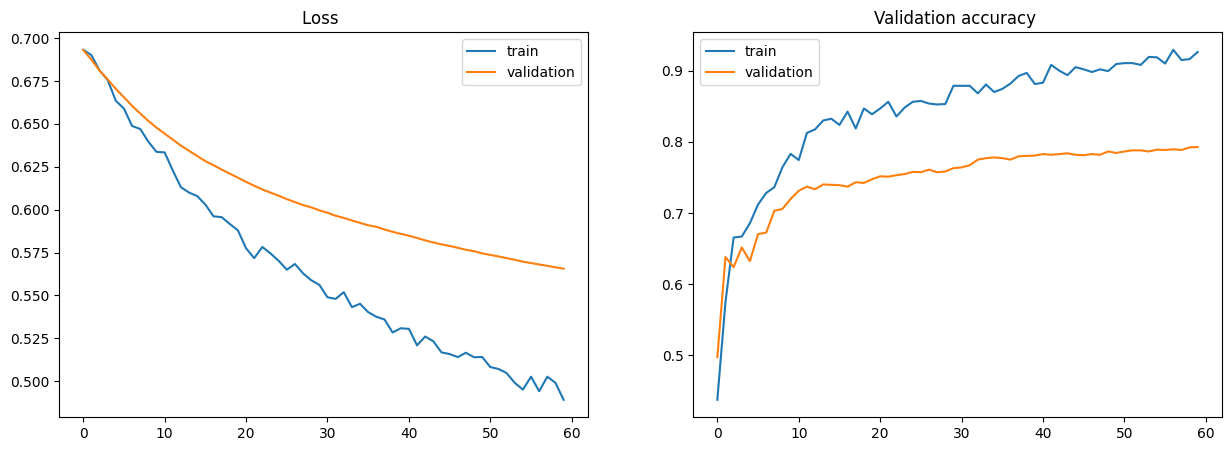

In [ ]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []

for k in vocab_sizes_list:
    counts = Counter(' '.join(texts_train).split())
    bow_vocabulary = [key for key, val in counts.most_common(k)]

    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

    model = Model()
    model = model.to(device)

    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    X_train_bow_torch = torch.tensor(X_train_bow)
    X_test_bow_torch = torch.tensor(X_test_bow)

    y_train_torch = torch.tensor(y_train)
    y_test_torch = torch.tensor(y_test)

    bow_nn_model = train_model(model, opt, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, n_iterations=3000)


    predicted_probas_on_test_for_k_sized_dict = bow_nn_model(X_test_bow_torch.to(device)).cpu().detach().numpy()[:, 1]
    assert predicted_probas_on_test_for_k_sized_dict is not None
    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)

In [ ]:
X_train_bow_torch.dtype

torch.float32

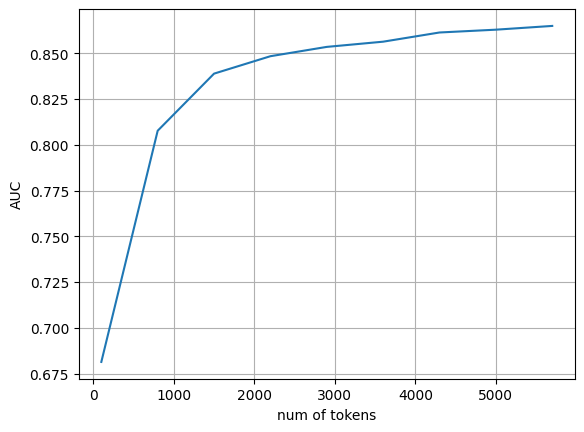

In [ ]:
# Не меняйте блок кода ниже!

# __________start of block__________
assert len(results) == len(vocab_sizes_list), 'Check the code above'
assert min(results) >= 0.65, 'Seems like the model is not trained well enough'
assert results[-1] > 0.84, 'Best AUC ROC should not be lower than 0.84'

plt.plot(vocab_sizes_list, results)
plt.xlabel('num of tokens')
plt.ylabel('AUC')
plt.grid()

out_dict['bow_k_vary'] = results
# __________end of block__________

In [ ]:
out_dict

{'bow_log_reg_sklearn_train': 0.9977842611208917,
 'bow_log_reg_sklearn_test': 0.8631857970254992,
 'bow_nn_torch_train': 0.98415753914651,
 'bow_nn_torch_test': 0.8673293097805819,
 'bow_k_vary': [0.6813931161803575,
  0.8077158926709512,
  0.8389145540477803,
  0.8484356092029257,
  0.8535266610202109,
  0.8563741708353675,
  0.8613950949767928,
  0.8629313803409836,
  0.8649841098297256]}

### Задача №2: Использование TF-iDF признаков.

Для векторизации текстов также можно воспользоваться TF-iDF. Это позволяет исключить из рассмотрения многие слова, не оказывающие значимого влияния при оценке непохожести текстов.

В лекции уже упоминалось про то, как векторизовать отдельные токены с помощью этого подхода. Соответственно, векторным представлением текста будет являться вектор размера словаря, где в компоненте с номером N будет указано значение TF-IDF в данном тексте для токена с индексом N.

Подробнее про TF-iDF можно почитать, например, [здесь](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089).
Там же можно почитать о его самостоятельной реализации.

Ваша задача: векторизовать тексты используя TF-iDF (или `TfidfVectorizer` из `sklearn`, или реализовав его самостоятельно) и построить классификатор с помощью PyTorch, аналогичный задаче №1.

Затем также оцените качество классификации по AUC ROC для различных размеров словаря.

Качество классификации должно быть не ниже 0.86 AUC ROC.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

class Model_tfidf(nn.Module):
  def __init__(self, lenvocab):
    super().__init__()
    self.fc = nn.Linear(lenvocab, 2)

  def forward(self, x):
    x = self.fc(x)
    return F.sigmoid(x)

counts = Counter(' '.join(texts_train).split())
vocab = [key for key, val in counts.most_common(min(10000, len(set(' '.join(texts_train).split()))))]

vectorizer = TfidfVectorizer(vocabulary=vocab)
vectorizer = vectorizer.fit(texts_train)

model = Model_tfidf(len(vocab))
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train_tfidf = vectorizer.transform(texts_train)
X_train_tfidf_torch = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)

X_test_tfidf = vectorizer.transform(texts_test)
X_test_tfidf_torch = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

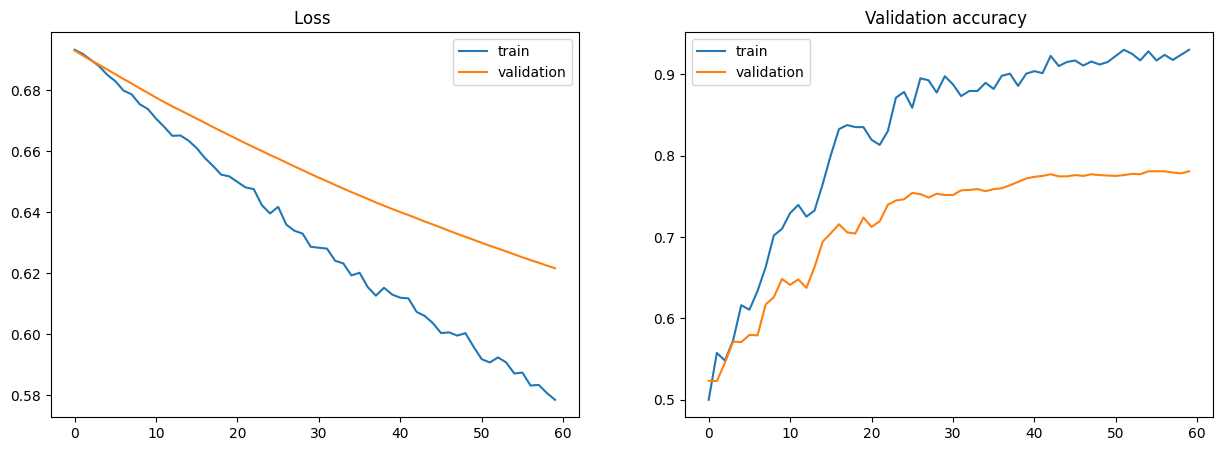

In [ ]:
model_tf_idf = train_model(model, opt, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=3000)

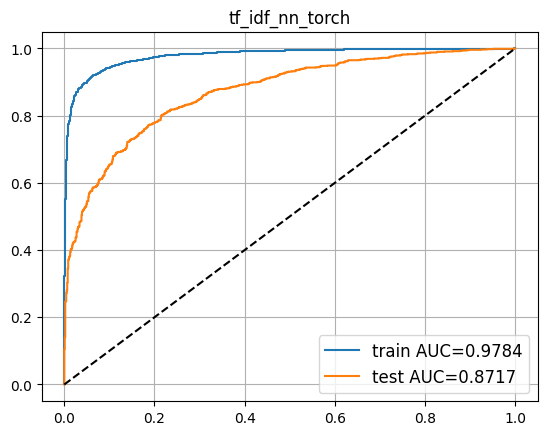

In [ ]:
# Не меняйте блок кода ниже!

# __________start of block__________
out_dict = visualize_and_save_results(model_tf_idf, 'tf_idf_nn_torch', X_train_tfidf_torch, X_test_tfidf_torch, y_train, y_test, out_dict)

assert out_dict['tf_idf_nn_torch_test'] >= out_dict['bow_nn_torch_test'], 'AUC ROC on test data should be better or close to BoW for TF-iDF features'
# __________end of block__________

Аналогично задаче №1 повторите процедуру обучения для различных значений `k` – размера словаря и сохраните `AUC ROC` на тестовой части выборки в список `results`.

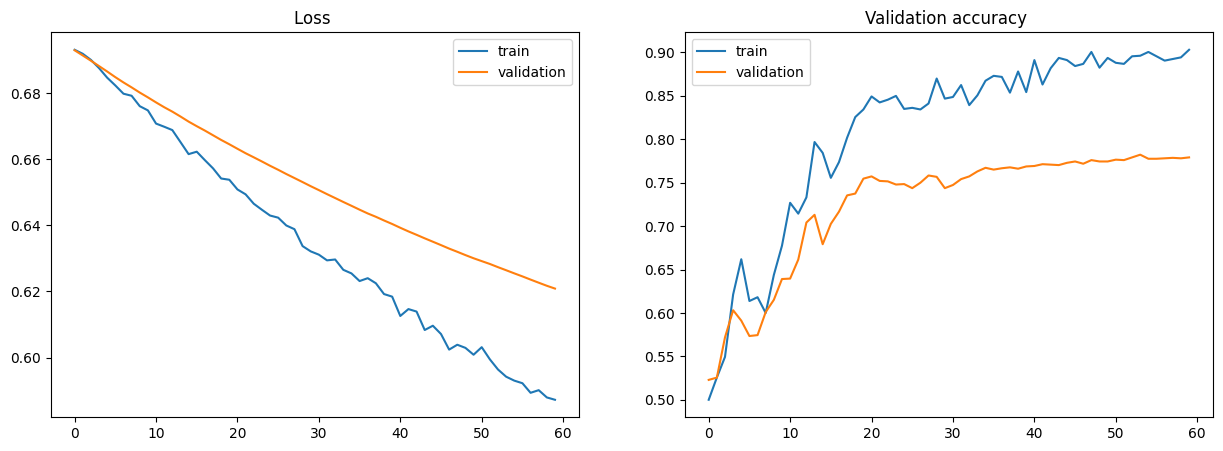

In [ ]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []

for k in vocab_sizes_list:

    counts = Counter(' '.join(texts_train).split())
    vocab = [key for key, val in counts.most_common(k)]

    vectorizer = TfidfVectorizer(vocabulary=vocab)
    vectorizer = vectorizer.fit(texts_train)

    model = Model_tfidf(len(vocab))
    model = model.to(device)

    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    X_train_tfidf = vectorizer.transform(texts_train)
    X_train_tfidf_torch = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)

    X_test_tfidf = vectorizer.transform(texts_test)
    X_test_tfidf_torch = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

    y_train_torch = torch.tensor(y_train)
    y_test_torch = torch.tensor(y_test)

    model_tf_idf = train_model(model, opt, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=3000)


    predicted_probas_on_test_for_k_sized_dict = model_tf_idf(X_test_tfidf_torch.to(device)).cpu().detach().numpy()[:, 1]
    assert predicted_probas_on_test_for_k_sized_dict is not None
    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)

In [ ]:
results

[0.669615472013621,
 0.8106123287715914,
 0.8380452970423516,
 0.848212179165883,
 0.8566405472785568,
 0.8600175482277269,
 0.8650368414929692,
 0.8641849805001571,
 0.8685198493940207]

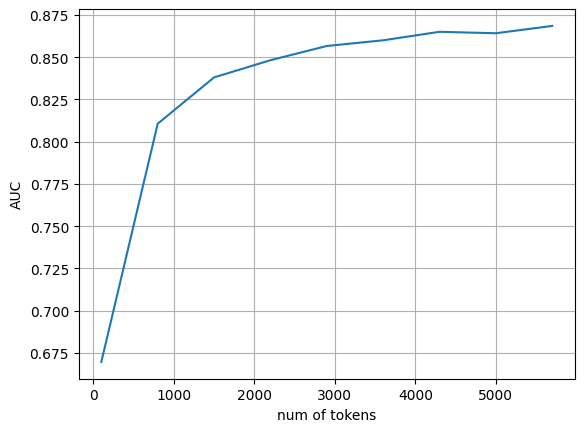

In [ ]:
# Не меняйте блок кода ниже!

# __________start of block__________
assert len(results) == len(vocab_sizes_list), 'Check the code above'
assert min(results) >= 0.65, 'Seems like the model is not trained well enough'
assert results[-1] > 0.85, 'Best AUC ROC for TF-iDF should not be lower than 0.84'

plt.plot(vocab_sizes_list, results)
plt.xlabel('num of tokens')
plt.ylabel('AUC')
plt.grid()

out_dict['tf_idf_k_vary'] = results
# __________end of block__________

In [ ]:
out_dict

{'bow_log_reg_sklearn_train': 0.9977842611208917,
 'bow_log_reg_sklearn_test': 0.8631857970254992,
 'bow_nn_torch_train': 0.9841062451841782,
 'bow_nn_torch_test': 0.8651200161782918,
 'bow_k_vary': [0.676246070947463,
  0.8035577020302234,
  0.8363046085299174,
  0.8477560774600952,
  0.8541137764460163,
  0.8605426903585862,
  0.8597870510605587,
  0.8616897399404839,
  0.8630216221564315],
 'tf_idf_nn_torch_train': 0.9792097555986958,
 'tf_idf_nn_torch_test': 0.8692657034349514,
 'tf_idf_k_vary': [0.675444223490923,
  0.8096762058426683,
  0.8383475527615625,
  0.8517718382475257,
  0.8567144803321768,
  0.8627324134466829,
  0.8639376309457669,
  0.8645970485490094,
  0.8662485824967846]}

### Задача №3: Сравнение с Наивным Байесовским классификатором.

Классические модели все еще способны показать хороший результат во многих задачах. Обучите наивный байесовский классификатор на текстах, векторизованных с помощью BoW и TF-iDF и сравните результаты с моделями выше.

*Комментарий: обращаем ваше внимание, необходимо выбрать подходящее к данной задаче априорное распределение для признаков, т.е. выбрать верную версию классификатора из `sklearn`: `GaussianNB`, `MultinomialNB`, `ComplementNB`, `BernoulliNB`, `CategoricalNB`*

In [ ]:
X_train_tfidf, X_test_tfidf, X_train_bow.shape, X_test_bow.shape, X_train_tfidf_torch.shape

(<5000x5700 sparse matrix of type '<class 'numpy.float64'>'
 	with 70360 stored elements in Compressed Sparse Row format>,
 <1920x5700 sparse matrix of type '<class 'numpy.float64'>'
 	with 25621 stored elements in Compressed Sparse Row format>,
 (5000, 5700),
 (1920, 5700),
 torch.Size([5000, 5700]))

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB

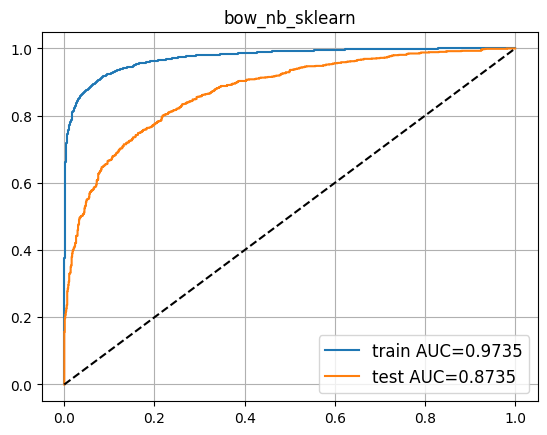

In [ ]:
clf_nb_bow = MultinomialNB()
clf_nb_bow = clf_nb_bow.fit(X_train_bow_torch, y_train)

# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(clf_nb_bow, 'bow_nb_sklearn', X_train_bow, X_test_bow, y_train, y_test, out_dict)
# __________end of block__________

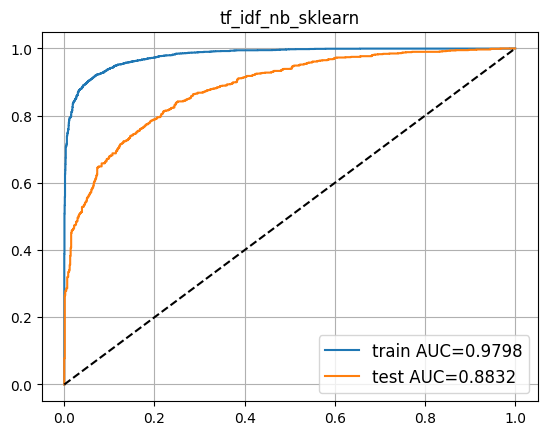

In [ ]:
clf_nb_tfidf = ComplementNB()
clf_nb_tfidf = clf_nb_tfidf.fit(X_train_tfidf_torch, y_train)


# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(clf_nb_tfidf, 'tf_idf_nb_sklearn', X_train_tfidf, X_test_tfidf, y_train, y_test, out_dict)
# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert out_dict['tf_idf_nb_sklearn_test'] > out_dict['bow_nb_sklearn_test'],' TF-iDF results should be better'
assert out_dict['tf_idf_nb_sklearn_test'] > 0.86, 'TF-iDF Naive Bayes score should be above 0.86'
# __________end of block__________

### Задача №4: Использование предобученных эмбеддингов

Наконец, воспользуемся предобученными эмбеддингами из библиотеки `gensim`. В нем доступно несколько эмбеддингов, предобученных на различных корпусах текстов. Полный список можно найти [здесь](https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models). Напоминаем, что лучше использовать те эмбеддинги, которые были обучены на текстах похожей структуры.

Ваша задача: обучить модель (достаточно логистической регрессии или же двуслойной неронной сети), используя усредненный эмбеддинг для всех токенов в отзыве, добиться качества не хуже, чем с помощью BoW/TF-iDF и снизить степень переобучения (разницу между AUC ROC на обучающей и тестовой выборках).

**Обратите внимание!**

В Google Colab установлена устаревшая версия библиотеки gensim, поэтому некоторые её обновлённые возможности могут не поддерживаться.

Например, может возникать ошибка AttributeError.

В этом случае нужно раскомментировать строку ниже, выполнить данную ячейку и повторно выполнить все последующие ячейки:

In [1]:
!pip install --upgrade gensim

In [2]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [3]:
import gensim.downloader as api
gensim_embedding_model = api.load('glove-wiki-gigaword-100')

In [179]:
def text_to_average_embedding(text, gensim_embedding_model=gensim_embedding_model):
    embedding_for_text = np.zeros(gensim_embedding_model.vector_size, dtype=np.float32)
    for word in text.split():
      embedding_for_text += gensim_embedding_model[word]
    return embedding_for_text / len(text)

In [193]:
'joff' in 'aczczd mad joff sda,'

True

In [ ]:
def try_repeat(func):
    def wrapper(*args, **kwargs):
      count = 2
      global doccc

      while count:
        try:
          func(["rain lazy", 'obama'])
        except Exception as e:
          word = str(e).split()[1][1:-1]
          for i, text in enumerate(doccc):
            doccc[i] = doccc[i].replace(' ' + word + ' ', ' ')
          count -= 1
          print(doccc)

    return wrapper

@try_repeat
def f(docs):
  return [text_to_average_embedding(text, gensim_embedding_model) for text in docs]

doccc = ['joff rain lazy', 'asdxzcz']
f(doccc), doccc

In [180]:

X_train_emb = [text_to_average_embedding(text, gensim_embedding_model) for text in texts_train]
X_test_emb = [text_to_average_embedding(text, gensim_embedding_model) for text in texts_test]

assert len(X_train_emb[0]) == gensim_embedding_model.vector_size, 'Seems like the embedding shape is wrong'

KeyError: "Key 'joff' not present"

In [ ]:
X_train_emb_torch = torch.tensor(X_train_emb)
X_test_emb_torch = torch.tensor(X_test_emb)

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

In [ ]:
class Model_pretrained(nn.Module):
  def __init__(self, lenemb):
    super().__init__()
    self.fc = nn.Linear(lenemb, 2)

  def forward(self, x):
    x = self.fc(x)
    return F.sigmoid(x)

model = Model_pretrained(gensim_embedding_model.vector_size)
model = model.to(device)

In [ ]:
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

model = train_model(model, opt, X_train_emb_torch, y_train_torch, X_test_emb_torch, y_test_torch, n_iterations=3000)

In [ ]:
# do not change the code in the block below
# __________start of block__________

out_dict = visualize_and_save_results(model, 'emb_nn_torch', X_train_emb_torch, X_test_emb_torch, y_train, y_test, out_dict)
assert out_dict['emb_nn_torch_test'] > 0.87, 'AUC ROC on test data should be better than 0.86'
assert out_dict['emb_nn_torch_train'] - out_dict['emb_nn_torch_test'] < 0.1, 'AUC ROC on test and train data should not be different more than by 0.1'
# __________end of block__________

### Сдача задания
Запустите код ниже для генерации посылки и сдайте на проверку файл `submission_dict_hw06.npy`.

In [4]:
out_dict = {'bow_log_reg_sklearn_train': 0.9977842611208917,
 'bow_log_reg_sklearn_test': 0.8631857970254992,
 'bow_nn_torch_train': 0.98415753914651,
 'bow_nn_torch_test': 0.8673293097805819,
 'bow_k_vary': [0.6813931161803575,
  0.8077158926709512,
  0.8389145540477803,
  0.8484356092029257,
  0.8535266610202109,
  0.8563741708353675,
  0.8613950949767928,
  0.8629313803409836,
  0.8649841098297256],
 'tf_idf_nn_torch_train': 0.9783999521683802,
 'tf_idf_nn_torch_test': 0.8716788565600907,
 'tf_idf_k_vary': [0.669615472013621,
  0.8106123287715914,
  0.8380452970423516,
  0.848212179165883,
  0.8566405472785568,
  0.8600175482277269,
  0.8650368414929692,
  0.8641849805001571,
  0.8685198493940207],
 'bow_nb_sklearn_train': 0.9734988140675616,
 'bow_nb_sklearn_test': 0.8734907599991737,
 'tf_idf_nb_sklearn_train': 0.9797984339632713,
 'tf_idf_nb_sklearn_test': 0.8831651175155015}

In [6]:
# Не меняйте блок кода ниже!
import numpy as np
# __________start of block__________

np.save('submission_dict_hw06.npy', out_dict, allow_pickle=True)
print('File saved to `submission_dict_hw06.npy`')
# __________end of block__________

File saved to `submission_dict_hw06.npy`


### Описание возможных ошибок

В Яндекс. Контест можно посмотреть вердикт по тестированию своей посылки. Для этого после проверки решения нужно открыть задачу на Яндекс. Контест и найтии внизу таблицу со списком отправленных посылок. Самая верхняя строка соответствует самой последней отправленной Вами посылке. В этой строке нужно  нажать справа на кнопку "Отчёт" (отмечена красным):



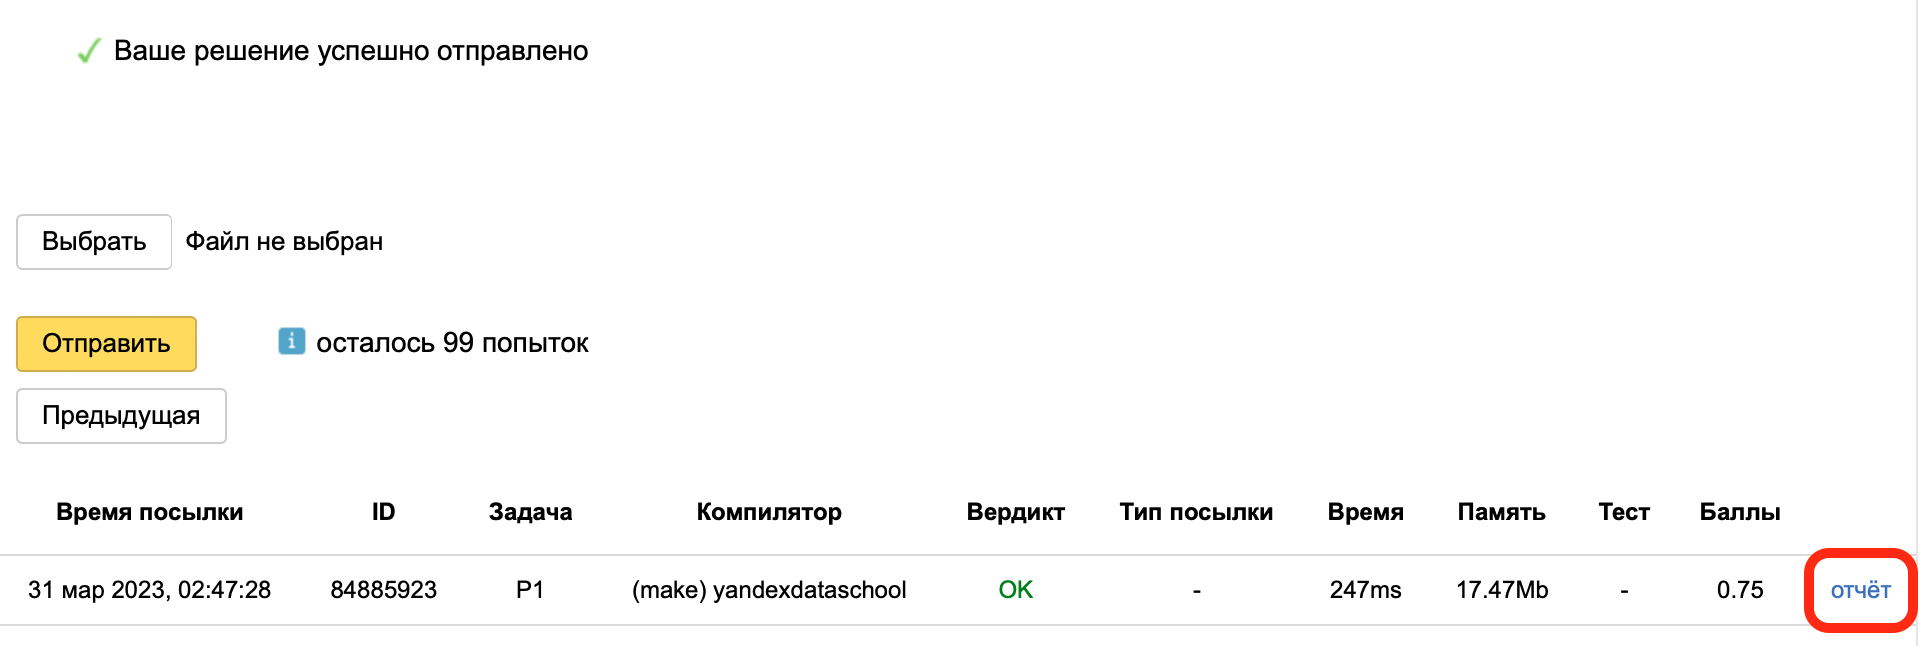

После этого у Вас откроется окно с информацием по тестированию Вашего решения:

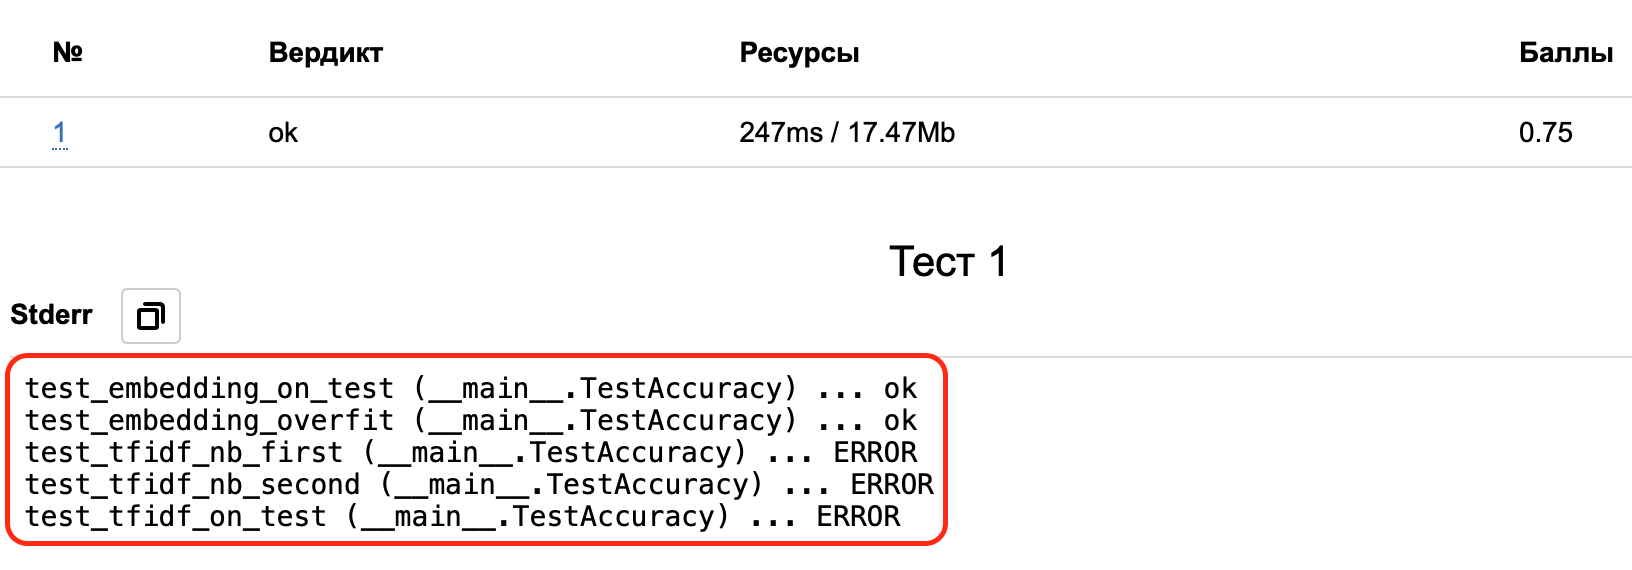

Ниже представлено краткое описание тестов и причин, по которым они не могут быть пройдены:

1. `test_tfidf_on_test` - значение ROC-AUC на тестовой выборке при применении TF-IDF к тестовому набору данных недостаточно высоко (см. условие).

2. `test_tfidf_nb_first` - возможно, выбрано некорректное распределение для Наивного Байесовского классификатора, качество для BoW превосходит TF-IDF.

3. `test_tfidf_nb_second` - возможно, выбрано некорректное распределение для Наивного Байесовского классификатора: качество на тестовой выборке ниже необходимого (см. условие).

4. `test_embedding_on_test` - недостаточно высокое качество для модели на основе эмбеддингов.

5. `test_embedding_overfit` - модель, использующая эмбеддинги, переобучается с большой долей вероятности.